## Программа Reboot 2020 поток 1 КУ Сбербанка
### выполнил Малинкин Павел Борисович
### Скрипт сбора информации с отзывами об услуге по выдаче ипотеки с последующим обучением модели классификации отзывов

In [ ]:
# Загрузим необходимые библиотеки
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
import json
import re
import random
import time

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# Выберем сайт для сбора данных
url = 'https://www.sravni.ru/ipoteka/otzyvy/'
feedbacks = []
estimates = []

# Обработка первой страницы
page = requests.get(url)
print(page, page.reason, page.encoding)
soup = BeautifulSoup(page.text, 'html.parser')

for tag in soup.find_all('div', attrs={'class':'_3p0dD'}):
    text = tag.text.lower()
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = text.strip()
    feedbacks.append(text)
        
for tag in soup.find_all('span', attrs={'class':'_1OBr6'}):
    estimates.append(int(tag.text))
print('feedbacks = {}, estimates = {}'.format(len(feedbacks), len(estimates)))

<Response [200]> OK utf-8
feedbacks = 20, estimates = 20


In [3]:
# Обработка последующих страниц с отзываним клиентов
last_page = 18
for i in range(2, last_page + 1):
    params = {'page': i}
    pouse = random.randint(10, 40)
    time.sleep(pouse)
    page = requests.get(url, params=params)
    print(page, page.reason, page.encoding)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    for tag in soup.find_all('div', attrs={'class':'_3p0dD'}):
        text = tag.text.lower()
        text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
        text = text.strip()
        feedbacks.append(text)
        
    for tag in soup.find_all('span', attrs={'class':'_1OBr6'}):
        estimates.append(int(tag.text))
    if (i % 10 == 0) or (i == last_page):
        print('page = {}, feedbacks = {}, estimates = {}'.format(i, len(feedbacks), len(estimates)))

<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
page = 10, feedbacks = 200, estimates = 200
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
<Response [200]> OK utf-8
page = 18, feedbacks = 360, estimates = 360


In [4]:
# Сформируем датасет для обучения
df_f = pd.DataFrame({'feedbacks':feedbacks})
df_e = pd.DataFrame({'labels':estimates})
df = pd.concat([df_e, df_f], axis=1)
print('lenght df = {}'.format(len(df)))

lenght df = 360


In [5]:
df.head()

,labels,feedbacks
0,4,брали ипотеку в далеком 2 14 году решения ждал...
1,2,обратившись в этот банк вы гарантировано получ...
2,2,у нас была оформлена ипотека в 2 17 в урал сиб...
3,3,из за просрочки у меня испортилась кредитная и...
4,3,не рекомендую обращаться за ипотекой в этот ба...


In [6]:
df.tail()

,labels,feedbacks
355,3,ипотека в банке втб подали заявление на пониже...
356,4,в июле 2 16 года взяла ипотеку в банке втб все...
357,3,добрый день надеюсь мой отзыв убережет вас от ...
358,3,взяли ипотеку в райффайзен на вторичку пожалел...
359,5,убрир нами был выбран не случайно сама работаю...


In [7]:
# Отзывы с оценками 1 и 2 отнесем к негативным, с 4 и 5 - к позитивным
df.loc[(df['labels'] == 1) | (df['labels'] == 2), 'labels'] = 0
df.loc[(df['labels'] == 4) | (df['labels'] == 5), 'labels'] = 1

In [8]:
# Исключим из выборки отзывы с оценкой 3
df = df[df['labels'] < 3]
print('Elements in dataset: {}'.format(len(df)))

Elements in dataset: 277


In [9]:
df.head()

,labels,feedbacks
0,1,брали ипотеку в далеком 2 14 году решения ждал...
1,0,обратившись в этот банк вы гарантировано получ...
2,0,у нас была оформлена ипотека в 2 17 в урал сиб...
6,1,я очень рад что меня с орентировали на ваш бан...
7,1,второй год плачу по ипотеке в банке открытие р...


In [10]:
# Проверим данные на предмет наличия дублей
df = df.drop_duplicates()
len(df)

275

Для датасета я набрал 275 отзывов. Это, конечно, мало. Но так как я рассматриваю цель финального проекта - показать свои навыки работы с данными, то решил ограничится этим количеством из-за ограниченности во времени

In [19]:
# Проверим соотношение положительных и отризательных отзывов в датасете
df['labels'].value_counts(normalize=True)

1    0.603636
0    0.396364
Name: labels, dtype: float64

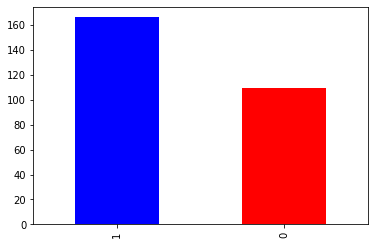

In [33]:
df['labels'].value_counts().plot(kind='bar', label='labels', color=['b','r'])

In [11]:
texts = df['feedbacks'].to_list()   # X
labels = df['labels'].to_list() # y

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [13]:
# Построим pipeline для обработки текста
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [14]:
# Попробуем разные виды моделей для классификации текста
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    print(clf)
    print(cross_val_score(text_classifier(CountVectorizer(), TfidfTransformer(), clf(max_iter=1000)), texts, labels, 
                         scoring='roc_auc').mean())
    print("\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.8478055978055977


<class 'sklearn.svm.classes.LinearSVC'>
0.8441577941577941


<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.8225075725075724




C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will ch

In [ ]:
# Вывод: Лучший результат показала модель LogisticRegression

In [15]:
# Попробуем варианты с n-граммами для улучшения работы модели
params = [(2,2), (3,3), (1,3)]
params[0]

for param in params:
    model = Pipeline(steps=[
            ("vectorizer", CountVectorizer(ngram_range=param)),
            ("classifier", LogisticRegression(max_iter=1000, random_state=2))
            ])
    model.fit(texts, labels)
    print(param, ' ', round(cross_val_score(model, texts, labels, cv=10, scoring='f1').mean(), 2))

C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

(2, 2)   0.78


C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

(3, 3)   0.75


C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

(1, 3)   0.8


In [ ]:
# Вывод: лучший результат показала модель с парамерами n-грамм (1, 3)

In [16]:
# Сохраним модель для последующего использования в web сервисе
import pickle

with open('model_ipoteka.pkl', 'wb') as f:
    pickle.dump(model, f)  

In [17]:
# Удалим временные объекты
del df_f, df_e, df

In [34]:
# Проверка работы модели
text = """
Я очень рад, что меня с орентировали на ваш банк! Решение об одобрении не заставило меня долго ждать, 
был приятно удивлен процентной ставкой! Большое спасибо работнику банка, а именно Наталье и Елене Задорожной! 
Терпеливо отнеслись к продавцу квартиры! Сделка прошла просто на одном дыхании, а так же дружелюбный и заботливый 
коллектив банка сделал отмасферу домашнего уюта и спокойствия! Хочу заметить- здесь аккредетив бесплатно и договор 
купли продажи тоже готовят бесплатно. Страхование вообще не ожидал, то что передлагают др. банки....(коллективное страхование) 
здесь гораздо дешевле. Спасибо большое, буду рекомендовать!
"""
print(model.predict([text]))
print(model.predict_proba([text])[0][1])

[1]
0.9874522503352516


In [35]:
text = """
Обратившись в этот банк, вы гарантировано получаете полное безразличие и совершенно неприемлемое отношение к себе. 
27.06 были согласованы документы и пришло одобрение на ипотеку более чем 9 млн руб. 
Стоимость недвижимости мы выбрали 7800. Личные средства в размере 10%. Все условия были согласованы. 
Менеджер З-ва Кристина на этапе согласования никогда не звонила, не информировала и даже игноривала, 
если возьмет с 5 раза трубку, когда вы звоните, то считай повезло. На этом мытарства не заканчиваются. 
Сроки рассмотрения документов как по нам, так и по объекту нарушены были 3 раза. 
Оставленные заявки с жалобами по телефону абсолютно никак не ускорили дело, видимо начальству тоже глубоко наплевать на вас 
как на клиентов. Но все-так после очередного обращения уже непосредственно переводят в банк на руководителя ипотечного 
кредитования С-ка Павла по адресу Москва Новоясеневский пр д 9. О чудо, думаем мы, наконец-то спустя 2 месяца хоть кто-то 
займется нами! На подписание дкп были приглашены 5.08 и так как сделка была альтернативной, помимо продавцов была 
еще куча людей, которых "обнадежил" банк ВТБ. Каково же было удивление, когда нам принесли довогор в котором была 
прописана сумма в 6 млн 240 тыс кредитных средств. Т.е банк нам одобрил не 90%, а 80. И ВОВРЕМЯ конечно никто из менеджеров, 
которым звонили постоянно, к которым приходили и согласовывали, не предупредил. Вот так прекрасно относятся к своим клиентам 
в банке ВТБ. К слову ни управляющая, которая пафосно заявила, что у менеджеров много клиентов, типа одним больше- одним меньше,
ни один из выше перечисленных менеджеров даже не извинились. В этот же день была написана жалоба на этих лиц с просьбой 
привлечь к ответственности за дезинформацию, ждем результата и если такового не дождемся, логичнее всего будет подать иск в суд
"""
print(model.predict([text]))
print(model.predict_proba([text])[0][1])

[0]
0.049719984319014095
